#  VLCCs MEG/China Supply Trend & Market Rates, implementing Filters

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/Combined%20Examples/VLCCs_MEG_China_Supply_Trend_Versus_Market_Rates_with_Implementing_Filters.ipynb).


---
**APIs Used:** Tonnage List, Market Rates


---





**Description:**

The goal of this example is to plot the supply trend alongside predicted market rates, providing insights into market behavior. We are calling the Historical Tonnage List twice for two different scenarios: one with a Laycan End of 10 days and the other with 20 days. For both cases, Excel files are generated containing the full dataset. Subsequently, we apply filtering and grouping across various layers, such as Open Areas and Commercial Status, ultimately producing the Supply Trend Chart.



---

**Output:** Excel Files for different scenarios, Supply Trend Chart


# Installation and imports

In [ ]:
#@title
!pip install signal-ocean
from datetime import datetime,date, timedelta
import pandas as pd
import matplotlib.pyplot as plt

from signal_ocean import Connection
from signal_ocean.market_rates import MarketRatesAPI, CargoId
from signal_ocean.tonnage_list import IndexLevel
from signal_ocean.tonnage_list import (
    TonnageListAPI,
    VesselClassFilter,
    PortFilter,
    VesselFilter,
    MarketDeployment,
    CommercialStatus,
    VesselSubclass,
    DateRange,
    PushType,
    OperationalStatus,
)
pd.set_option('display.max_columns', None)

# Supply and Market Rates Set

We need to specify the following parameters for our queries:


1.   route_description - the route of interest with available market rates.
2.   port_name - the loading port.

1.   vessel_class - the class of queried vessels.
2.   laycan_end_in_days - the maximum estimated time of arrival for available vessels to reach the loading port.
1.   days_to_look_back - the number of days the supply trend should reach back, starting from the current date.
2.   latest_ais_since_value - how many days since the vessel has transmitted its AIS data.

1.   vessel_subclass - the type of oil product the vessel is classified to carry
2.   market_deployment - the vessels' market deployment.














In [ ]:
signal_ocean_api_key = ''  #replace with your subscription key
customer_name='Internal'
route_description = "VLCC - MEG/China"
port_name="Ras Tanura"
vessel_class="VLCC"
laycan_end_in_days_20 = 20
laycan_end_in_days_10 = 10
scenario_name_20 = vessel_class+"-"+port_name+"-"+str(laycan_end_in_days_20)+"days"
scenario_name_10 = vessel_class+"-"+port_name+"-"+str(laycan_end_in_days_10)+"days"
days_to_look_back = 180
latest_ais_since_value = 5

vessel_filter = VesselFilter(
    vessel_subclass=VesselSubclass.DIRTY,
    latest_ais_since=latest_ais_since_value,
    market_deployments=[MarketDeployment.RELET, MarketDeployment.SPOT], # Only Relevant for Tankers
    #push_types=[PushType.PUSHED_POSS, PushType.PUSHED], # TSOP: Pushed State
    #commercial_statuses= [CommercialStatus.ON_SUBS] #[CommercialStatus.AVAILABLE, CommercialStatus.ON_SUBS, CommercialStatus.FAILED, CommercialStatus.CANCELLED], # TSOP: Availability State
    #operational_statuses=[OperationalStatus.BALLAST_UNFIXED] #, OperationalStatus.BALLAST_FIXED], # TSOP: Voyage State
)


# Getting the Data

In [ ]:
connection = Connection(signal_ocean_api_key)
api = TonnageListAPI(connection)

market_rate_api = MarketRatesAPI(connection)


In [ ]:
vessel_class_filter = VesselClassFilter(name_like=vessel_class)
vessel_class = api.get_vessel_classes(vessel_class_filter)[0]
vessel_class


VesselClass(id=84, name='VLCC')

In [ ]:
port_filter = PortFilter(name_like=port_name)
port = api.get_ports(port_filter)[0]
port


Port(id=3778, name='Ras Tanura')

In [ ]:
start_date = date.today() - timedelta(days_to_look_back)
end_date = date.today()



htl_for_supply_trend_20days = api.get_historical_tonnage_list(
    port,
    vessel_class,
    laycan_end_in_days_20,
    DateRange(start_date, end_date),
    vessel_filter=vessel_filter,
)
supply_trend_data_20_frame = htl_for_supply_trend_20days.to_data_frame()


htl_for_supply_trend_10days = api.get_historical_tonnage_list(
    port,
    vessel_class,
    laycan_end_in_days_10,
    DateRange(start_date, end_date),
    vessel_filter=vessel_filter,
)
supply_trend_data_10_frame = htl_for_supply_trend_10days.to_data_frame()

# Saving Full Dataset to Excel

In [ ]:

supply_trend_data_20_frame["open_date_point_in_time"] = pd.to_datetime(supply_trend_data_20_frame["open_date_point_in_time"]).dt.tz_localize(None)
supply_trend_data_20_frame["eta_point_in_time"] = pd.to_datetime(supply_trend_data_20_frame["eta_point_in_time"]).dt.tz_localize(None)
supply_trend_data_20_frame["latest_ais_point_in_time"] = pd.to_datetime(supply_trend_data_20_frame["latest_ais_point_in_time"]).dt.tz_localize(None)

remove_time_zones_20 = (
    supply_trend_data_20_frame.reset_index()
    .set_index(IndexLevel.IMO)
)
remove_time_zones_20["date"] = pd.to_datetime(remove_time_zones_20["date"]).dt.tz_localize(None)




supply_trend_data_10_frame["open_date_point_in_time"] = pd.to_datetime(supply_trend_data_10_frame["open_date_point_in_time"]).dt.tz_localize(None)
supply_trend_data_10_frame["eta_point_in_time"] = pd.to_datetime(supply_trend_data_10_frame["eta_point_in_time"]).dt.tz_localize(None)
supply_trend_data_10_frame["latest_ais_point_in_time"] = pd.to_datetime(supply_trend_data_10_frame["latest_ais_point_in_time"]).dt.tz_localize(None)

remove_time_zones_10 = (
    supply_trend_data_10_frame.reset_index()
    .set_index(IndexLevel.IMO)
)
remove_time_zones_10["date"] = pd.to_datetime(remove_time_zones_10["date"]).dt.tz_localize(None)

In [ ]:
now = datetime.now() # current date and time
remove_time_zones_20.to_excel(now.strftime("%Y.%m.%d-%H:%M:%S-")+customer_name+'-'+scenario_name_20+'.xlsx')
remove_time_zones_10.to_excel(now.strftime("%Y.%m.%d-%H:%M:%S-")+customer_name+'-'+scenario_name_10+'.xlsx')

# Areas Filtering

In [ ]:
open_areas = [
"Indonesia",
"Singapore / Malaysia",
"Thailand / Vietnam",
"Papua New Guinea",
"Philippines",
"South China",
"Central China",
"North China",
"Taiwan",
"Japan Island",
"Korea",
"Russian Pacific"
]

###########################################################################
areas_filter_20 = supply_trend_data_20_frame.open_narrow_area_point_in_time.isin(
    open_areas
)

supply_trend_data_20_frame = (
    supply_trend_data_20_frame[areas_filter_20]
)

###########################################################################
areas_filter_10 = supply_trend_data_10_frame.open_narrow_area_point_in_time.isin(
    open_areas
)

supply_trend_data_10_frame = (
    supply_trend_data_10_frame[areas_filter_10]
)

# Grouping and Filtering the data

In [ ]:


aggregated_data = supply_trend_data_20_frame.groupby(
    IndexLevel.DATE, sort=True
).size()
aggregated_data = aggregated_data.to_frame()
aggregated_data.reset_index(drop=False, inplace=True)
aggregated_data['date'] = aggregated_data['date'].dt.date
aggregated_data.columns = ['date', '20days']



aggregated_data_10 = supply_trend_data_10_frame.groupby(
    IndexLevel.DATE, sort=True
).size()
aggregated_data_10 = aggregated_data_10.to_frame()
aggregated_data_10.reset_index(drop=False, inplace=True)
aggregated_data_10['date'] = aggregated_data_10['date'].dt.date
aggregated_data_10.columns = ['date', '10days']

merge_df = pd.merge(aggregated_data_10, aggregated_data, left_on='date', right_on='date', how='right')
#aggregated_data


In [ ]:
ballast_unfixed = ["Ballast Unfixed"]

ballast_unfixed_filter = supply_trend_data_20_frame.operational_status_point_in_time.isin(
    ballast_unfixed
)

ballast_unfixed_dataframe = (
    supply_trend_data_20_frame[ballast_unfixed_filter]
)

ballast_unfixed_dataframe = ballast_unfixed_dataframe.groupby(
    IndexLevel.DATE, sort=True
).size()
ballast_unfixed_dataframe = ballast_unfixed_dataframe.to_frame()
ballast_unfixed_dataframe.reset_index(drop=False, inplace=True)
ballast_unfixed_dataframe['date'] = ballast_unfixed_dataframe['date'].dt.date
ballast_unfixed_dataframe.columns = ['date', 'ballast_unfixed_20']

ballast_unfixed_dataframe

merge_df = pd.merge(merge_df, ballast_unfixed_dataframe, left_on='date', right_on='date', how='left')



In [ ]:
commercial_status = ["On Subs"]

on_subs_filter = supply_trend_data_20_frame.commercial_status_point_in_time.isin(
    commercial_status
)

on_subs_dataframe = (
    supply_trend_data_20_frame[on_subs_filter]
)

on_subs_dataframe = on_subs_dataframe.groupby(
    IndexLevel.DATE, sort=True
).size()
on_subs_dataframe = on_subs_dataframe.to_frame()
on_subs_dataframe.reset_index(drop=False, inplace=True)
on_subs_dataframe['date'] = on_subs_dataframe['date'].dt.date
on_subs_dataframe.columns = ['date', 'on_subs_20']


merge_df = pd.merge(merge_df, on_subs_dataframe, left_on='date', right_on='date', how='left')

In [ ]:
pushed_status = ["Pushed","Pushed POSS"]

pushed_filter = supply_trend_data_20_frame.push_type_point_in_time.isin(
    pushed_status
)

pushed_dataframe = (
    supply_trend_data_20_frame[pushed_filter]
)

pushed_dataframe = pushed_dataframe.groupby(
    IndexLevel.DATE, sort=True
).size()
pushed_dataframe = pushed_dataframe.to_frame()
pushed_dataframe.reset_index(drop=False, inplace=True)
pushed_dataframe['date'] = pushed_dataframe['date'].dt.date
pushed_dataframe.columns = ['date', 'pushed_20']


merge_df = pd.merge(merge_df, pushed_dataframe, left_on='date', right_on='date', how='left')

# Getting the Rates

In [ ]:
def return_selected_route(vessel_class, route_description):
    vessel_routes = market_rate_api.get_routes(vessel_class_id=vessel_class.id)
    for i, _ in enumerate(vessel_routes):
        if vessel_routes[i].description == route_description:
            break
    return vessel_routes[i]


In [ ]:




today = date.today()
start_date = today - timedelta(days_to_look_back)
end_date = today

market_rate_route = return_selected_route(vessel_class, route_description)

market_rates = market_rate_api.get_market_rates(
    start_date,
    route_id=market_rate_route.id,
    vessel_class_id=vessel_class.id,
    end_date=end_date,
    cargo_id=CargoId(market_rate_route.cargo_id)
)



In [ ]:
market_rates_dataframe = pd.DataFrame([vars(vr) for vr in market_rates])
market_rates_dataframe["rate_date"] = pd.to_datetime(market_rates_dataframe["rate_date"])
market_rates_dataframe['rate_date'] = market_rates_dataframe['rate_date'].dt.date
market_rates_dataframe['route_id'] = route_description
market_rates_dataframe

,route_id,rate_date,rate_value,unit,vessel_class_id,deprecated_to
0,VLCC - MEG/China,2024-06-19,50.0,WS,84,None
1,VLCC - MEG/China,2024-06-20,49.5,WS,84,None
2,VLCC - MEG/China,2024-06-21,49.0,WS,84,None
3,VLCC - MEG/China,2024-06-22,49.0,WS,84,None
4,VLCC - MEG/China,2024-06-23,49.0,WS,84,None
...,...,...,...,...,...,...
176,VLCC - MEG/China,2024-12-12,39.5,WS,84,None
177,VLCC - MEG/China,2024-12-13,39.0,WS,84,None
178,VLCC - MEG/China,2024-12-14,39.0,WS,84,None
179,VLCC - MEG/China,2024-12-15,39.0,WS,84,None


In [ ]:
merge_df = pd.merge(market_rates_dataframe, merge_df, left_on='rate_date', right_on='date', how='left').drop(['rate_date', 'deprecated_to', 'vessel_class_id'], axis=1)

# Result Dataframe

In [ ]:
merge_df

,route_id,rate_value,unit,date,10days,20days,ballast_unfixed_20,on_subs_20,pushed_20
0,VLCC - MEG/China,50.0,WS,2024-06-19,5.0,58,48,10.0,53.0
1,VLCC - MEG/China,49.5,WS,2024-06-20,2.0,51,40,3.0,49.0
2,VLCC - MEG/China,49.0,WS,2024-06-21,1.0,55,39,5.0,53.0
3,VLCC - MEG/China,49.0,WS,2024-06-22,6.0,56,44,6.0,54.0
4,VLCC - MEG/China,49.0,WS,2024-06-23,6.0,62,47,5.0,56.0
...,...,...,...,...,...,...,...,...,...
176,VLCC - MEG/China,39.5,WS,2024-12-12,1.0,39,30,2.0,30.0
177,VLCC - MEG/China,39.0,WS,2024-12-13,NaN,42,30,1.0,35.0
178,VLCC - MEG/China,39.0,WS,2024-12-14,NaN,50,34,2.0,41.0
179,VLCC - MEG/China,39.0,WS,2024-12-15,4.0,56,41,2.0,47.0


In [ ]:
merge_df.to_excel(now.strftime("%Y.%m.%d-%H:%M:%S-")+customer_name+'-'+route_description.replace("/", "-")+'.xlsx')

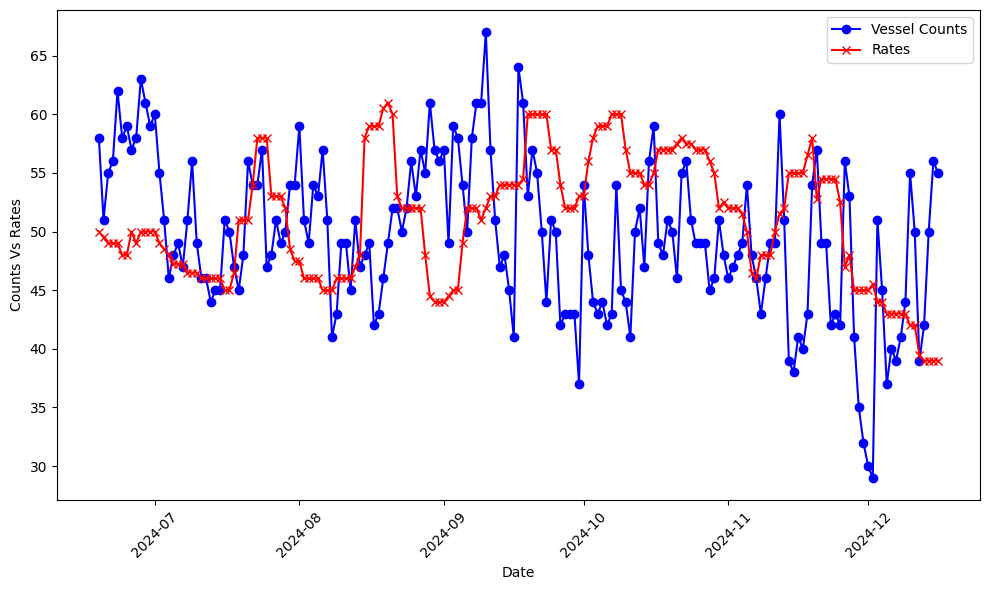

In [ ]:

merge_df = merge_df.dropna(subset=['date'])
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.plot(merge_df['date'], merge_df['20days'], label='Vessel Counts', color='b', marker='o')
plt.plot(merge_df['date'], merge_df['rate_value'], label='Rates', color='r', marker='x')

plt.xlabel('Date')
plt.ylabel('Counts Vs Rates')
plt.title('')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()

plt.tight_layout()  # Adjust layout to make room for labels
plt.show()